# Cross-validation, Bootstrap and Decision Trees

## Cross-validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error


In [2]:
df_auto = pd.read_csv("auto.csv")
df_auto['horsepower'] = pd.to_numeric(df_auto['horsepower'], errors='coerce')
df_auto = df_auto.dropna(subset=['horsepower'])

In [22]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [23]:
df_auto.head(20)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl


MSE for degrees 1–11: [23.61661707 18.76303135 18.79694163 18.77852784 18.44907879 18.64919219
 18.68969042 18.60310219 18.63987162 19.06753846 20.0926824 ]


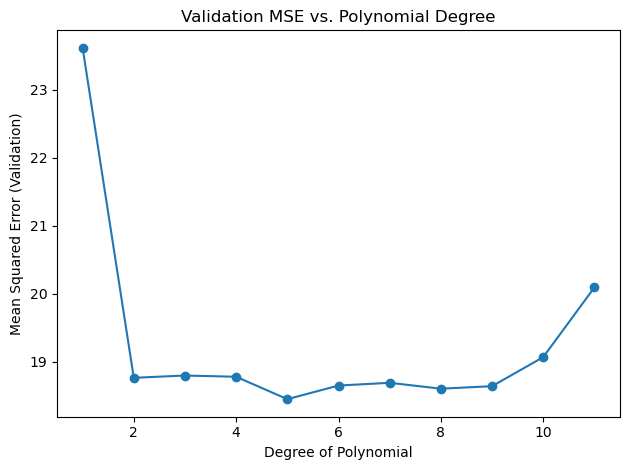

In [8]:
X = df_auto[['horsepower']].values
y = df_auto['mpg'].values

# Single 50/50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Loop degrees 1..11
mses = []
for deg in range(1, 12):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_tr = poly.fit_transform(X_train)
    X_te = poly.transform(X_test)
    
    # fit and evaluate
    model = LinearRegression().fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    mses.append(mean_squared_error(y_test, y_pred))

# as NumPy array
mse_array = np.array(mses)
print("MSE for degrees 1–11:", mse_array)

plt.figure()
plt.plot(range(1,12), mse_array, marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error (Validation)')
plt.title('Validation MSE vs. Polynomial Degree')
plt.tight_layout()
plt.show()

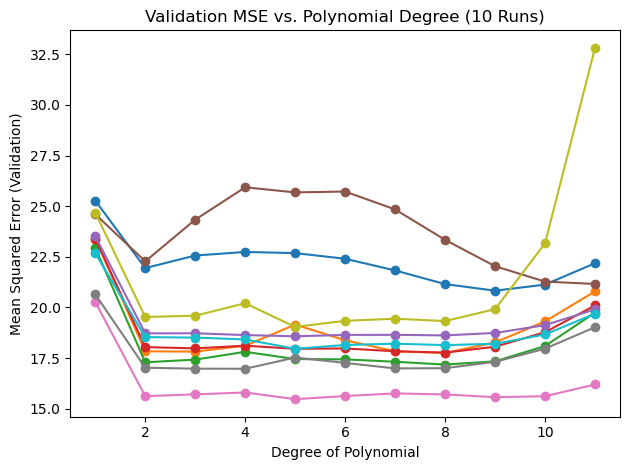

In [9]:
n_runs = 10
degrees = list(range(1, 12))
all_mses = np.zeros((n_runs, len(degrees)))

# Repeat the 50/50 split experiment n_runs times
for run in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    for i, deg in enumerate(degrees):
        # Build polynomial features up to 'deg'
        poly = PolynomialFeatures(degree=deg, include_bias=False)
        X_tr = poly.fit_transform(X_train)
        X_te = poly.transform(X_test)
        
        # Fit and evaluate
        model = LinearRegression().fit(X_tr, y_train)
        y_pred = model.predict(X_te)
        all_mses[run, i] = mean_squared_error(y_test, y_pred)

# Plot all runs on the same figure
plt.figure()
for run in range(n_runs):
    plt.plot(degrees, all_mses[run], marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error (Validation)')
plt.title('Validation MSE vs. Polynomial Degree (10 Runs)')
plt.tight_layout()
plt.show()

### Leave-One-Out Cross-validation (LOOCV)

Degree  1 → LOOCV MSE = 24.232
Degree  2 → LOOCV MSE = 19.248
Degree  3 → LOOCV MSE = 19.335
Degree  4 → LOOCV MSE = 19.424
Degree  5 → LOOCV MSE = 19.033
Degree  6 → LOOCV MSE = 19.166
Degree  7 → LOOCV MSE = 19.127
Degree  8 → LOOCV MSE = 19.012
Degree  9 → LOOCV MSE = 19.173
Degree 10 → LOOCV MSE = 19.906
Degree 11 → LOOCV MSE = 21.483


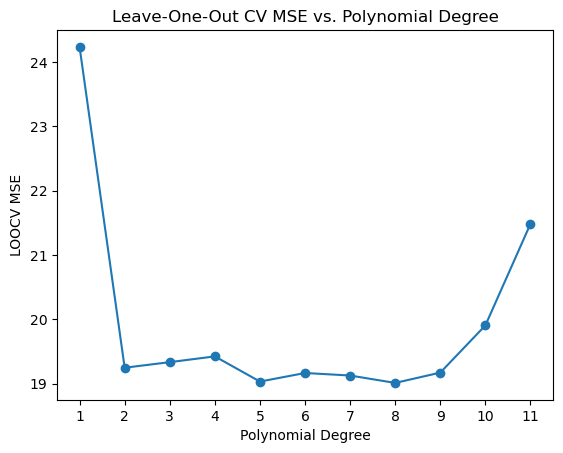

In [10]:

loo = LeaveOneOut()

# Loop over degrees 1..11 and collect LOOCV MSE
loocv_mses = []
for deg in range(1, 12):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    # cross_val_score returns neg-MSE, so take the negative of the mean
    neg_mses = cross_val_score(LinearRegression(), X_poly, y, cv=loo, scoring='neg_mean_squared_error')
    loocv_mses.append(-neg_mses.mean())

# Inspect or plot the results
for deg, mse in zip(range(1,12), loocv_mses):
    print(f"Degree {deg:2d} → LOOCV MSE = {mse:.3f}")

# Plot Degree vs. LOOCV MSE
plt.plot(range(1,12), loocv_mses, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('LOOCV MSE')
plt.title('Leave-One-Out CV MSE vs. Polynomial Degree')
plt.xticks(range(1,12))
plt.show()

### k-fold Cross-Validation

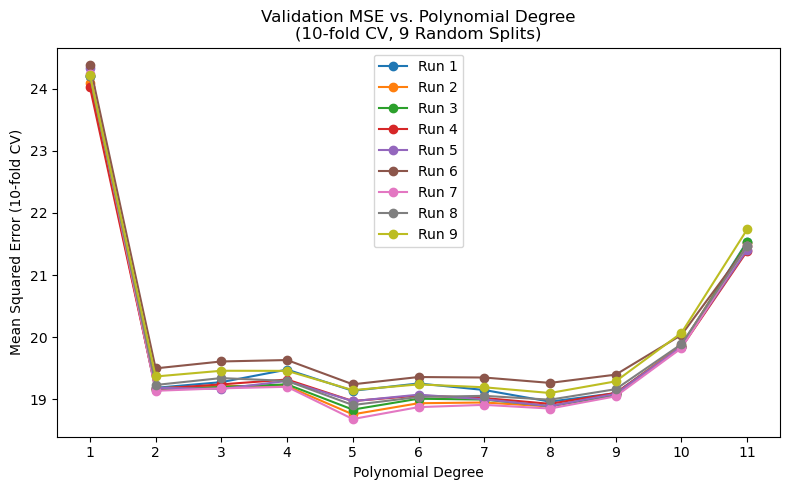

In [12]:

degrees = list(range(1, 12))  # polynomial degrees 1..11
n_runs  = 9                   # how many random 10-fold splits

# -- 3) Container for MSEs --
all_mses = np.zeros((n_runs, len(degrees)))

# -- 4) Loop over runs and degrees --
for run in range(n_runs):
    cv = KFold(n_splits=10, shuffle=True, random_state=run)
    for i, deg in enumerate(degrees):
        # build features horsepower^1 … horsepower^deg
        poly    = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly  = poly.fit_transform(X)
        # compute 10-fold CV (neg-MSE)
        neg_mses = cross_val_score(LinearRegression(), X_poly, y, cv=cv, scoring='neg_mean_squared_error')
        # store the positive MSE
        all_mses[run, i] = -neg_mses.mean()

#  Plot all runs together --
plt.figure(figsize=(8,5))
for run in range(n_runs):
    plt.plot(degrees, all_mses[run], marker='o', label=f'Run {run+1}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (10-fold CV)')
plt.title('Validation MSE vs. Polynomial Degree\n(10-fold CV, 9 Random Splits)')
plt.xticks(degrees)
plt.legend()
plt.tight_layout()
plt.show()

## Bootstrap

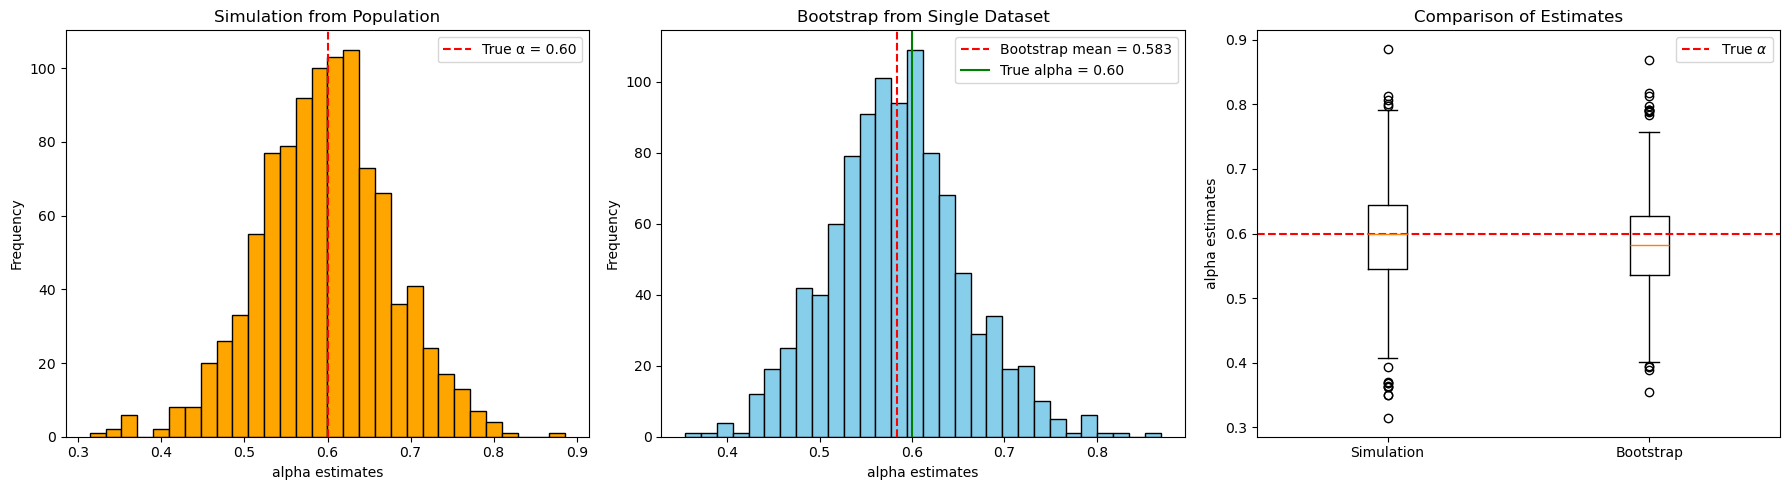

True alpha: 0.600
Bootstrap alpha mean:  0.583
Bootstrap SE estimate: 0.073


In [72]:
np.random.seed(0)

# True parameters
sigma_x2 = 1.
sigma_y2 = 1.25
cov_xy = 0.5
true_alpha = (sigma_y2 - cov_xy) / (sigma_x2 + sigma_y2 - 2 * cov_xy)

# Simulation settings
n = 100       # sample size
M = 1000      # number of simulated datasets
B = 1000      # number of bootstrap samples

# Covariance matrix
cov_matrix = np.array([[sigma_x2, cov_xy],
                       [cov_xy, sigma_y2]])

# 1) Simulation from the true population
alphas_sim = np.empty(M)
for i in range(M):
    data = np.random.multivariate_normal(mean=[0,0], cov=cov_matrix, size=n)
    X, Y = data[:,0], data[:,1]
    var_x = np.var(X, ddof=1)
    var_y = np.var(Y, ddof=1)
    cov_hat = np.cov(X, Y, ddof=1)[0,1]
    alphas_sim[i] = (var_y - cov_hat) / (var_x + var_y - 2 * cov_hat)

# 2) Generate one dataset and bootstrap
data0 = np.random.multivariate_normal(mean=[0,0], cov=cov_matrix, size=n)
X0, Y0 = data0[:,0], data0[:,1]

alphas_boot = np.empty(B)
for b in range(B):
    idx = np.random.choice(n, size=n, replace=True)
    Xb, Yb = X0[idx], Y0[idx]
    var_xb = np.var(Xb, ddof=1)
    var_yb = np.var(Yb, ddof=1)
    cov_b = np.cov(Xb, Yb, ddof=1)[0,1]
    alphas_boot[b] = (var_yb - cov_b) / (var_xb + var_yb - 2 * cov_b)

alpha_boot_mean = alphas_boot.mean()
alpha_boot_se = np.sqrt(np.sum((alphas_boot - alpha_boot_mean)**2) / (B - 1))

# 3) Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: simulation histogram
axes[0].hist(alphas_sim, bins=30, color='orange', edgecolor='black')
axes[0].axvline(true_alpha, color='red', linestyle='--', label=f'True α = {true_alpha:.2f}')
axes[0].set_title('Simulation from Population')
axes[0].set_xlabel('alpha estimates')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Center: bootstrap histogram
axes[1].hist(alphas_boot, bins=30, color='skyblue', edgecolor='black')
axes[1].axvline(alpha_boot_mean, color='red', linestyle='--', label=f'Bootstrap mean = {alpha_boot_mean:.3f}')
axes[1].axvline(true_alpha, color='green', linestyle='-', label=f'True alpha = {true_alpha:.2f}')
axes[1].set_title('Bootstrap from Single Dataset')
axes[1].set_xlabel('alpha estimates')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Right: boxplots
axes[2].boxplot([alphas_sim, alphas_boot], tick_labels=['Simulation', 'Bootstrap'])
axes[2].axhline(true_alpha, color='red', linestyle='--', label=r'True $\alpha$')
axes[2].set_title('Comparison of Estimates')
axes[2].set_ylabel('alpha estimates')
axes[2].legend()

plt.tight_layout()
plt.show()

# Print summary
print(f"True alpha: {true_alpha:.3f}")
print(f"Bootstrap alpha mean:  {alpha_boot_mean:.3f}")
print(f"Bootstrap SE estimate: {alpha_boot_se:.3f}")


## Decision Trees

In [2]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, _tree

In [4]:
df_hitters = pd.read_csv("Hitters.csv")
df_hitters.info()
df_hitters.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  322 non-null    int64  
 1   AtBat       322 non-null    int64  
 2   Hits        322 non-null    int64  
 3   HmRun       322 non-null    int64  
 4   Runs        322 non-null    int64  
 5   RBI         322 non-null    int64  
 6   Walks       322 non-null    int64  
 7   Years       322 non-null    int64  
 8   CAtBat      322 non-null    int64  
 9   CHits       322 non-null    int64  
 10  CHmRun      322 non-null    int64  
 11  CRuns       322 non-null    int64  
 12  CRBI        322 non-null    int64  
 13  CWalks      322 non-null    int64  
 14  League      322 non-null    object 
 15  Division    322 non-null    object 
 16  PutOuts     322 non-null    int64  
 17  Assists     322 non-null    int64  
 18  Errors      322 non-null    int64  
 19  Salary      263 non-null    f

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,0,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,1,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,2,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,3,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,4,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [5]:
df_hitters_cln = df_hitters.dropna()
df_hitters_cln.info()
df_hitters_cln.head()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    int64  
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    float6

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,1,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,2,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,3,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,4,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,5,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


## Regression Trees

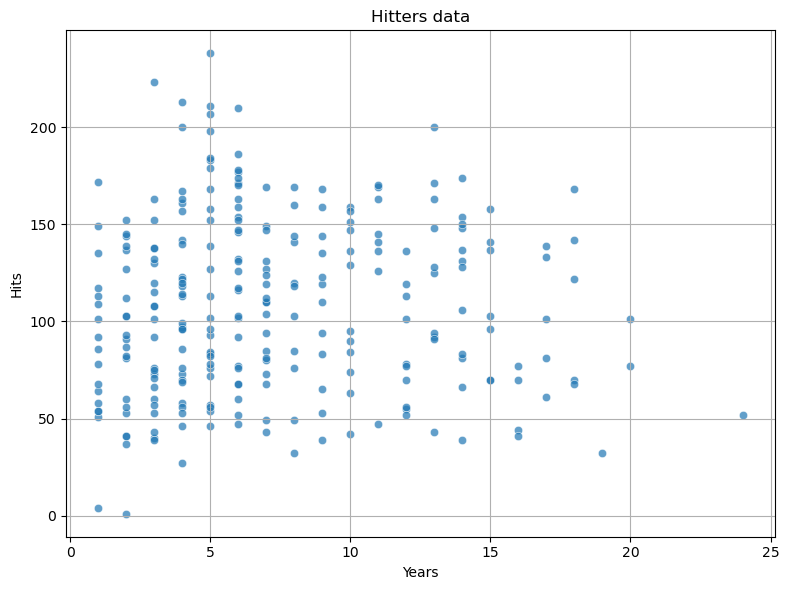

In [5]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_hitters_cln, x="Years", y="Hits", alpha=0.7)
plt.title("Hitters data")
plt.xlabel("Years")
plt.ylabel("Hits")
plt.grid(True)
plt.tight_layout()
plt.show()

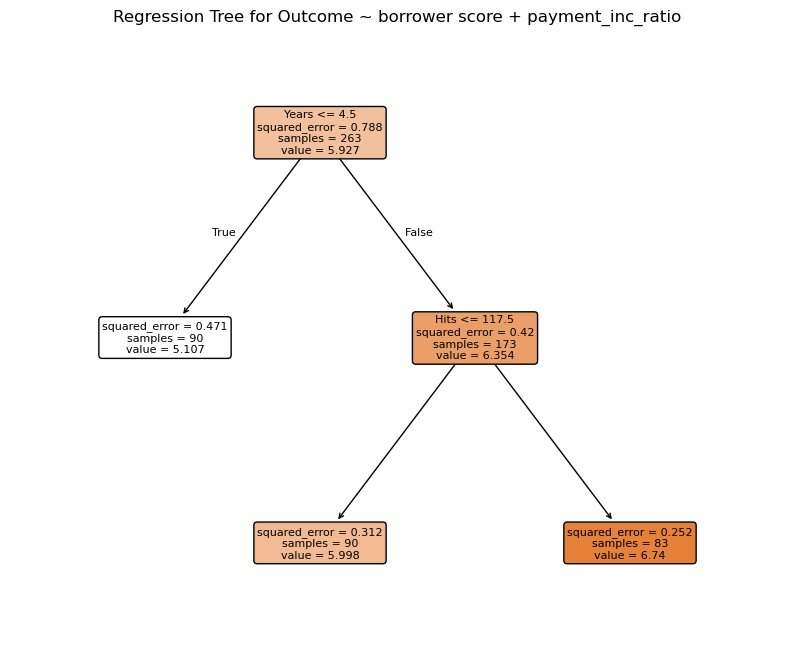

In [7]:
X = df_hitters_cln[['Years','Hits']]
y = np.log(df_hitters_cln['Salary'])

tree_model = DecisionTreeRegressor(max_leaf_nodes=3)
tree_model.fit(X,y)

plt.figure(figsize=(10, 8))
plot_tree(tree_model, feature_names=['Years','Hits'], filled=True, rounded=True, fontsize=8)
plt.title("Regression Tree for Outcome ~ borrower score + payment_inc_ratio")
plt.show()

In [8]:
print(tree_model.score(X, y))

0.5591199525164692


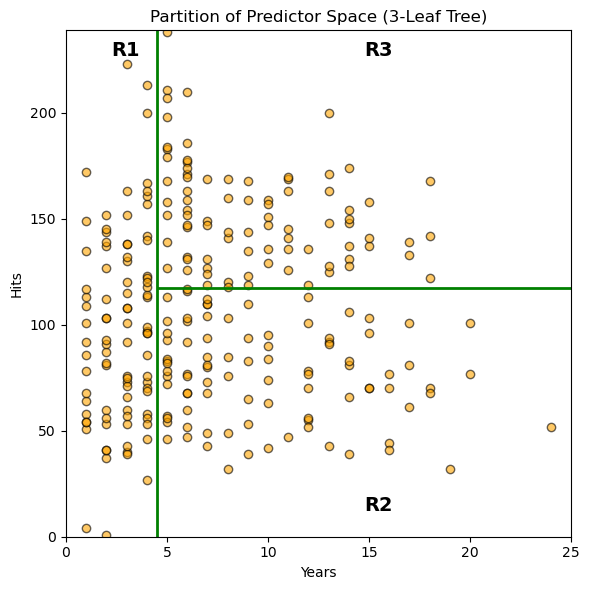

In [39]:
root_threshold   = tree.threshold[0]  # first split on Years
right_child_node = tree.children_right[0]  # index of right child
second_threshold = tree.threshold[right_child_node] # second split on Hits

# Scatter plot and partition lines
years = X['Years'].values
hits  = X['Hits'].values
x_min, x_max = years.min() - 1, years.max() + 1
y_min, y_max = hits.min() - 1, hits.max() + 1

plt.figure(figsize=(6,6))
plt.scatter(years, hits, color='orange', alpha=0.6, edgecolor='k')

# vertical line at Years = root_threshold
plt.vlines(root_threshold, y_min, y_max, color='green', linewidth=2)
# horizontal line at Hits = second_threshold
plt.hlines(second_threshold, root_threshold, x_max, color='green', linewidth=2)

# Label the three regions
plt.text((x_min + root_threshold)/2, y_max - (y_max - y_min)*0.05,'R1', fontsize=14, fontweight='bold', color='black')

plt.text((root_threshold + x_max)/2, y_min + (y_max - y_min)*0.05, 'R2', fontsize=14, fontweight='bold', color='black')

plt.text((root_threshold + x_max)/2, y_max - (y_max - y_min)*0.05, 'R3', fontsize=14, fontweight='bold', color='black')


plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Years')
plt.ylabel('Hits')
plt.title('Partition of Predictor Space (3-Leaf Tree)')
plt.tight_layout()
plt.show()

## Tree Prunning

In [9]:
hitters_df = pd.read_csv("Hitters.csv")

features = ['Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'PutOuts', 'Assists', 'Errors']

# Preprocessing
print(f"Original number of observations: {len(hitters_df)}")
hitters_df = hitters_df.dropna(how='any')
hitters_df['Salary'] = np.log(hitters_df['Salary'])
print(f"Number of observations after handling missing salaries: {len(hitters_df)}")

# Separate features and target
X = hitters_df[features]
y = hitters_df['Salary']

# Split the data into training (132) and test (131) sets
# Note: The original text specifies the exact sizes. We use random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=132, random_state=0)

print(f"\nTraining set size: {len(X_train)} observations")
print(f"Test set size: {len(X_test)} observations")

Original number of observations: 322
Number of observations after handling missing salaries: 263

Training set size: 132 observations
Test set size: 131 observations


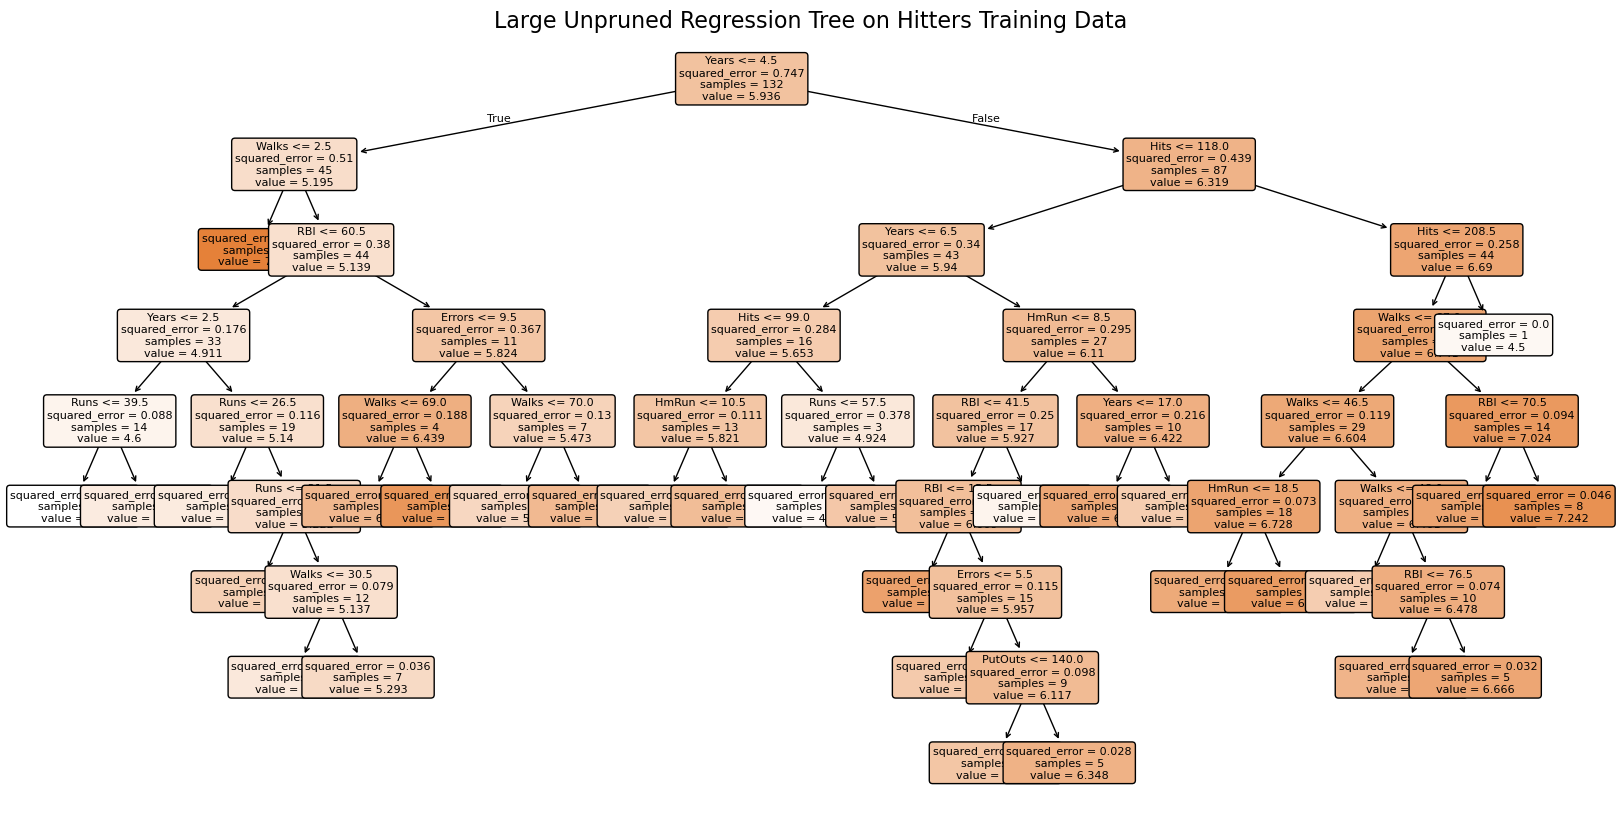

In [22]:
# --- Build and Plot the Initial Large Tree ---

# Create the large tree model. We don't constrain its depth to make it "large".
large_tree = DecisionTreeRegressor(max_leaf_nodes=30)
large_tree.fit(X_train, y_train)

# Plot the large, unpruned tree
plt.figure(figsize=(20, 10))
plot_tree(large_tree, feature_names=X.columns, filled=True, rounded=True, fontsize=8) 
plt.title("Large Unpruned Regression Tree on Hitters Training Data", fontsize=16)
plt.show()

In [23]:
# --- Pruning Path and 6-Fold Cross-Validation ---

# Get the cost complexity pruning path
path = large_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # Exclude the trivial tree

# Prepare lists to store results
train_mses = []
test_mses = []
cv_mses_mean = []
cv_mses_std = []
tree_sizes = []

# Perform 6-fold cross-validation (132 is a multiple of 6)
k_folds = 6
kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)

for ccp_alpha in ccp_alphas:
    regressor = DecisionTreeRegressor(random_state=1,ccp_alpha=ccp_alpha)

    # Calculate Cross-Validation MSE
    cv_scores = cross_val_score(regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_mses_mean.append(-np.mean(cv_scores))
    cv_mses_std.append(np.std(cv_scores) / np.sqrt(k_folds))

    # Fit the model on the full training data
    regressor.fit(X_train, y_train)

    # Store results
    tree_sizes.append(regressor.get_n_leaves())
    train_mses.append(mean_squared_error(y_train, regressor.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, regressor.predict(X_test)))

# Convert to numpy arrays
tree_sizes = np.array(tree_sizes)
train_mses = np.array(train_mses)
test_mses = np.array(test_mses)
cv_mses_mean = np.array(cv_mses_mean)
cv_mses_std = np.array(cv_mses_std)

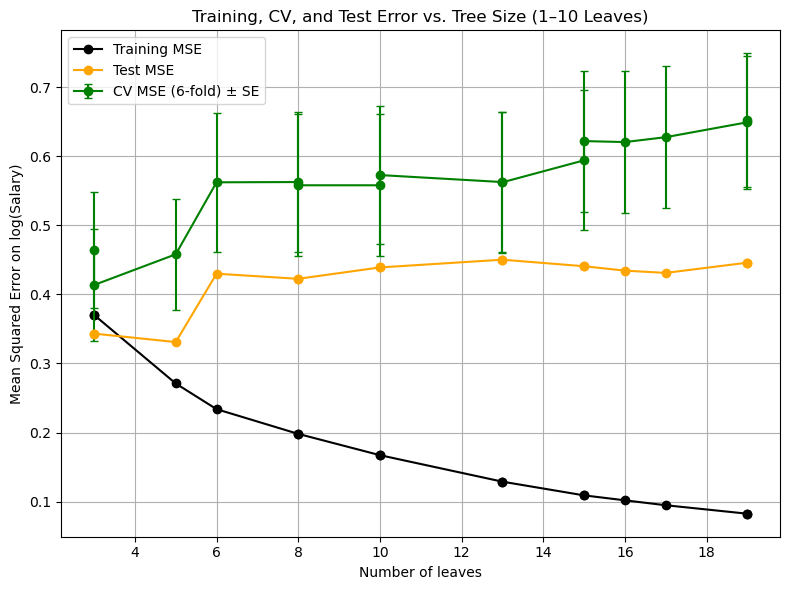

In [24]:

mask = tree_sizes <= 20
sizes = tree_sizes[mask]

plt.figure(figsize=(8, 6))
plt.plot(sizes, train_mses[mask], 'o-', color='black', label='Training MSE')
plt.errorbar(
    sizes,
    cv_mses_mean[mask],
    yerr=cv_mses_std[mask],
    fmt='o-',
    color='green',
    capsize=3,
    label='CV MSE (6-fold) ± SE'
)
plt.plot(sizes, test_mses[mask], 'o-', color='orange', label='Test MSE')

plt.xlabel("Number of leaves")
plt.ylabel("Mean Squared Error on log(Salary)")
plt.title("Training, CV, and Test Error vs. Tree Size (1–10 Leaves)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This pruned tree has 3 terminal nodes (5 total nodes).


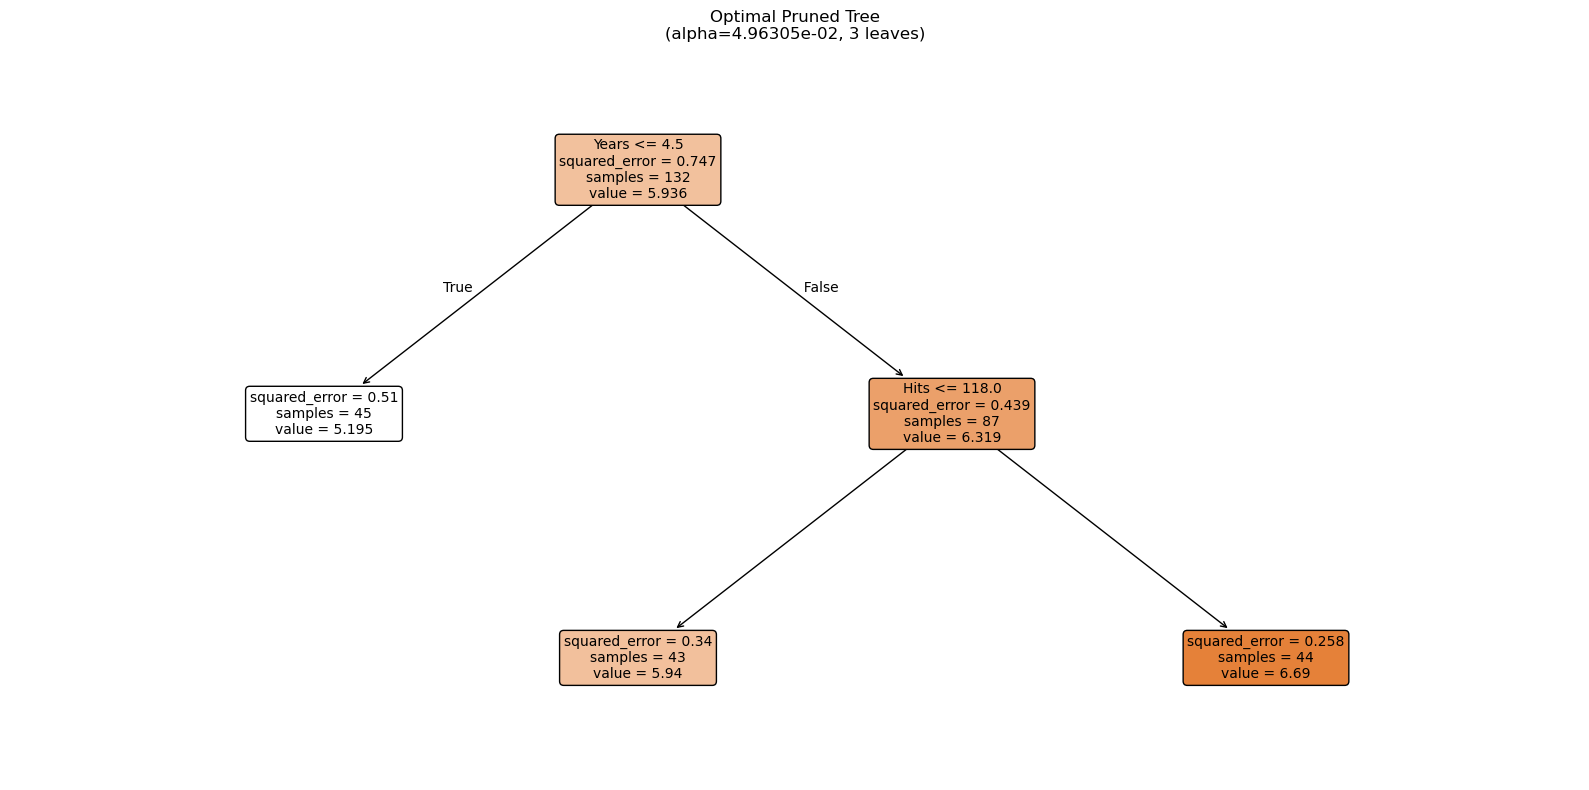

In [25]:
# 1) Find index of the smallest CV error
best_idx    = np.argmin(cv_mses_mean)
best_alpha  = ccp_alphas[best_idx]
best_size   = tree_sizes[best_idx]



# 2) Re-fit the tree on the full training set at that alpha
best_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=best_alpha)
best_tree.fit(X_train, y_train)

n_terminals = best_tree.get_n_leaves()
n_total     = best_tree.tree_.node_count

print(f"This pruned tree has {n_terminals} terminal nodes " 
      f"({n_total} total nodes).")

# 3) Plot the resulting pruned tree
plt.figure(figsize=(16, 8))
plot_tree(
    best_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    precision=3,
    fontsize=10
)
plt.title(f"Optimal Pruned Tree\n(alpha={best_alpha:.5e}, "
          f"{best_tree.get_n_leaves()} leaves)")
plt.tight_layout()
plt.show()